# 2/ Une approche collaborative

On regarde ensuite les notes obtenues selon les clusters de films pour chaque individu. On espère trouver des types d'individus : on aime l'action, et/ou on aime la comedie, ... 
  
On veut un dataframe avec, pour chaque utilisateur, la note moyenne qu'il a donné aux films qui appartiennent à chaque cluster . 

Le genre n'est pas explicatif pour la population globale, mais c'est peut être le cas pour certains d'individus.  
On crée un dataframe pref qui donne pour chaque utilisateur la note moyenne selon la catégorie. On normalise les ratings des utilisateurs.

On normalise les notes des utilisateurs 

In [76]:
df0=ratings.pivot(index='UserID',columns='MovieID',values='Rating').T

In [77]:
def standard(data_ref,data):
    #On retranche d'abord la moyenne 
    df=data.sub(data_ref.mean())
    std=df.std(axis = 0, skipna = True) 
    std[std==0]=1
    df=df/std
    return(df)

In [78]:
df1=standard(df0,df0)
#df1=(df0 - df0.min()) / (df0.max() - df0.min())
df1['MovieID']=pd.unique(ratings.sort_values(by='MovieID')['MovieID'])
del df1.index.name
df2=df.merge(df1,on='MovieID',how='inner')
index_movies=df2['MovieID']
index_movies=index_movies.to_frame()
df1=df1.merge(index_movies,on='MovieID',how='inner')
del df1['MovieID']

In [79]:
df3=pd.DataFrame()
for i in Cluster : 
    mask=df2[i]==1
    df3[i]=df1[mask].mean()

In [80]:
indiv_pref=df3.copy()
#on remplit les valeurs manquantes avec 
indiv_pref=indiv_pref.T
indiv_pref=indiv_pref.fillna(indiv_pref.mean())
indiv_pref=indiv_pref.T

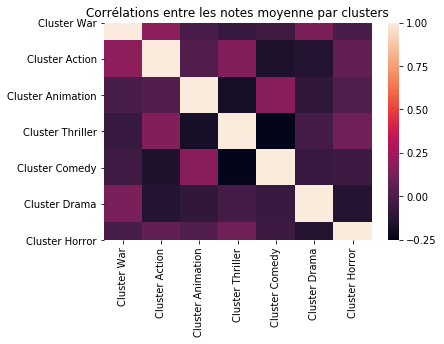

In [117]:
plt.title('Corrélations entre les notes moyenne par clusters')
sns.heatmap(indiv_pref.corr())


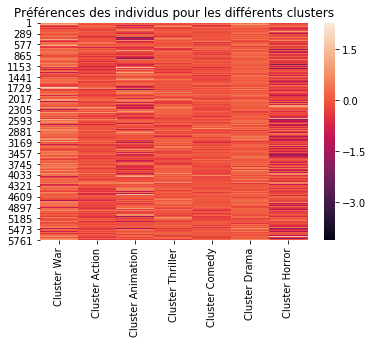

In [82]:
plt.title('Préférences des individus pour les différents clusters')
sns.heatmap(indiv_pref)

Certaines catégories font plus l'unanimité que d'autres.

## Un algorithme de clustering : la méthode k-means

In [83]:
X = indiv_pref

In [85]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

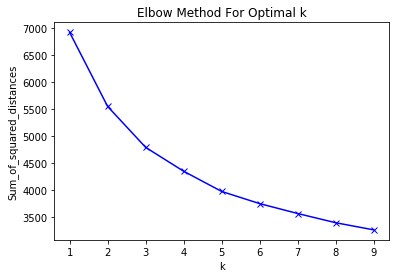

In [86]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

On trouve k=3 par la méthode du coude

In [119]:
X = indiv_pref
kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X)

In [120]:
# On trace selon les différents clusters
fig = px.scatter_3d(indiv_pref, x='Cluster Action', y='Cluster Drama',z='Cluster Animation',color=kmeans)
fig.show()

In [121]:
fig = px.scatter_3d(indiv_pref, x='Cluster Comedy', y='Cluster War',z='Cluster Thriller',color=kmeans)
fig.show()

## On represente les clusters d'individus dans le plan d'une ACP

In [122]:
#doit avoir des colonnes pour ACP 
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Calcul composantes principales 
pca=decomposition.PCA(n_comp)
pca.fit(X_scaled)
                
#display_scree_plot(pca)
coord=pca.fit_transform(X)
pcs=pca.components_
#display_circles(pcs,n_comp,pca,[(0,1),(2,3),(4,5)])

#print(pca.explained_variance_ratio_)
#print(pca.components_)

In [123]:
df_graph=pd.DataFrame(coord,columns=['x','y','z'])

In [124]:
fig = px.scatter_3d(df_graph, x='x', y='y',z='z',color=kmeans)
fig.show()

On cherche quelques statistiques pour savoir la pertinence des clusters pour déterminer une influence sur le rating 

In [125]:
df4=indiv_pref.copy()
df4['Cluster']=kmeans

On utilise ensuite sns.pairplot afin de visualiser selon les différents clusters

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



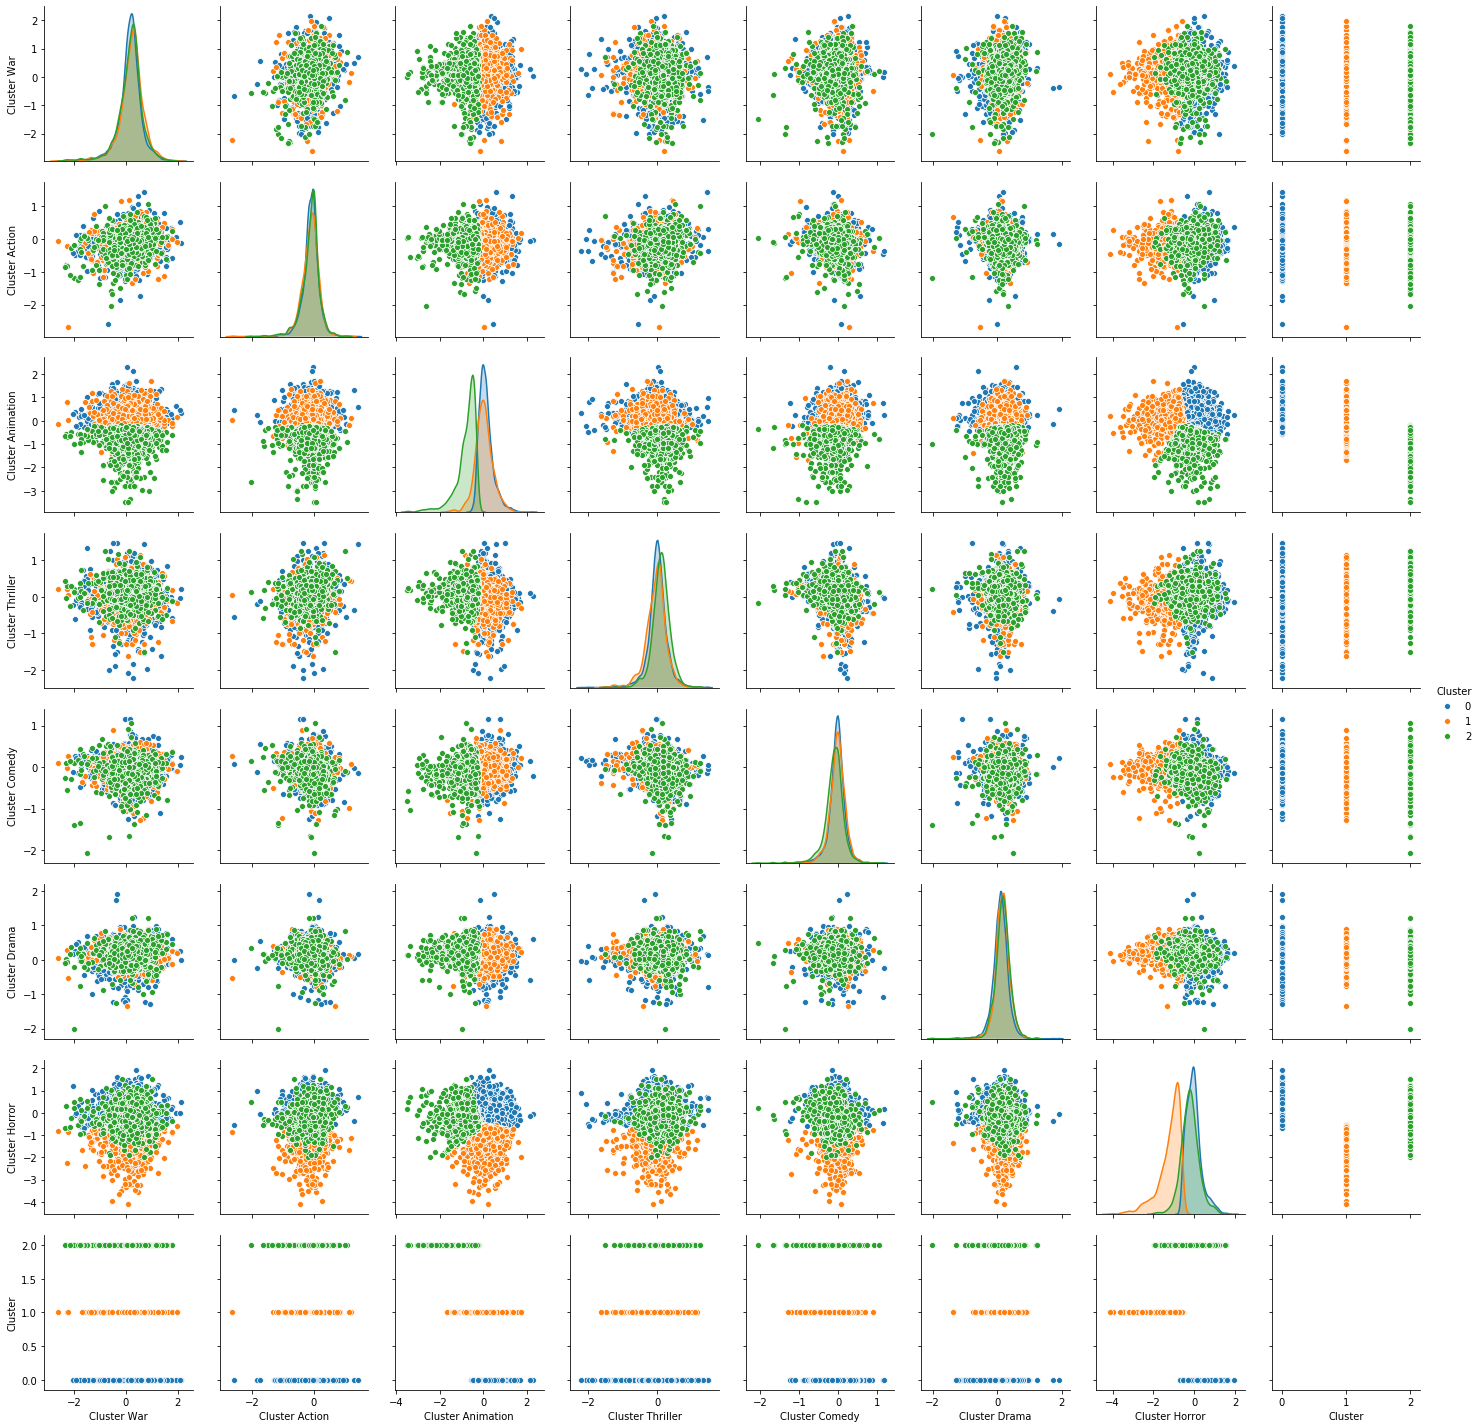

In [126]:
sns.pairplot(df4,hue='Cluster')

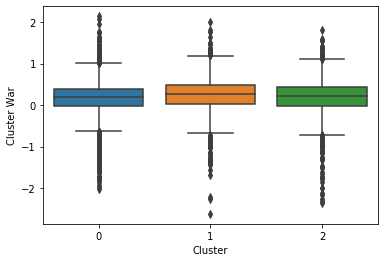

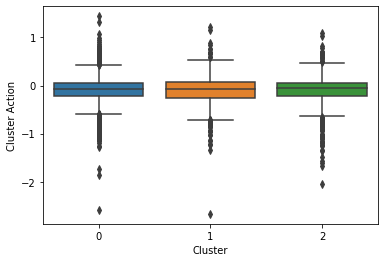

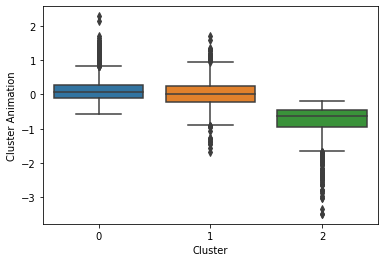

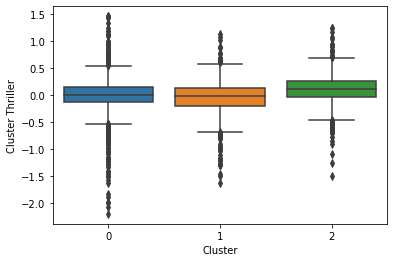

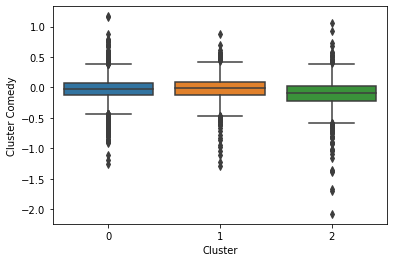

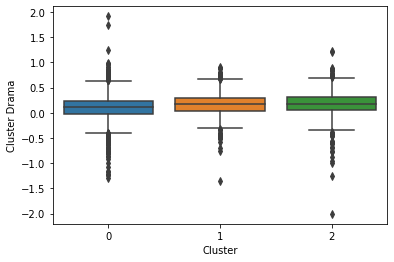

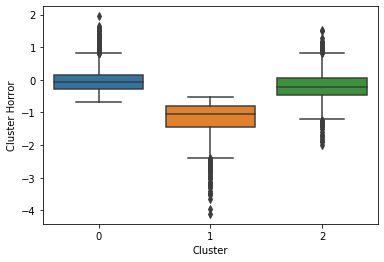

In [127]:
for i in Cluster:
    sns.boxplot(y=i,x='Cluster',data=df4)
    plt.show()


In [97]:
## On va maintenant tester un algorithme SVD pour obtenir la matrice complète des notes.

## Algorithme de SVD 

In [98]:
import numpy as np
from scipy.sparse.linalg import svds
from functools import partial


def emsvd(Y, k=None, tol=1E-3, maxiter=150):
    """
    Approximate SVD on data with missing values via expectation-maximization

    Inputs:
    -----------
    Y:          (nobs, ndim) data matrix, missing values denoted by NaN/Inf
    k:          number of singular values/vectors to find (default: k=ndim)
    tol:        convergence tolerance on change in trace norm
    maxiter:    maximum number of EM steps to perform (default: no limit)

    Returns:
    -----------
    Y_hat:      (nobs, ndim) reconstructed data matrix
    mu_hat:     (ndim,) estimated column means for reconstructed data
    U, s, Vt:   singular values and vectors (see np.linalg.svd and 
                scipy.sparse.linalg.svds for details)
    """

    if k is None:
        svdmethod = partial(np.linalg.svd, full_matrices=False)
    else:
        svdmethod = partial(svds, k=k)
    if maxiter is None:
        maxiter = np.inf

    # initialize the missing values to their respective column means
    mu_hat = np.nanmean(Y, axis=0, keepdims=1)
    valid = np.isfinite(Y)
    Y_hat = np.where(valid, Y, mu_hat)

    halt = False
    ii = 1
    v_prev = 0

    while not halt:
        
    # SVD on filled-in data
        U, s, Vt = svdmethod(Y_hat - mu_hat)

        # impute missing values
        Y_hat[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]

        # update bias parameter
        mu_hat = Y_hat.mean(axis=0, keepdims=1)

        # test convergence using relative change in trace norm
        v = s.sum()
        if v_prev==0:
            flag=1
        else:
            flag=v_prev
        if ii >= maxiter or ((v - v_prev) / flag) < tol:
            halt = True
        ii += 1
        #print(ii)
        #print((v - v_prev) / flag)
        v_prev = v
    return Y_hat, mu_hat, U, s, Vt

In [129]:
X=pd.DataFrame(emsvd(df3,k=2)[0])

In [130]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

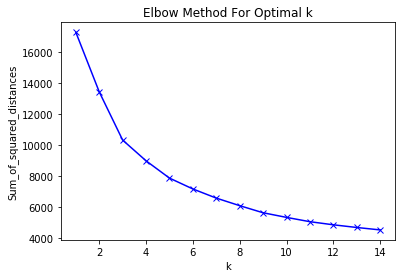

In [131]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

La méthode du coude nous donne qu'il faut prendre k=4 clusters

In [132]:
kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(X)

In [133]:
X=pd.DataFrame(X)
X['Cluster']=kmeans

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



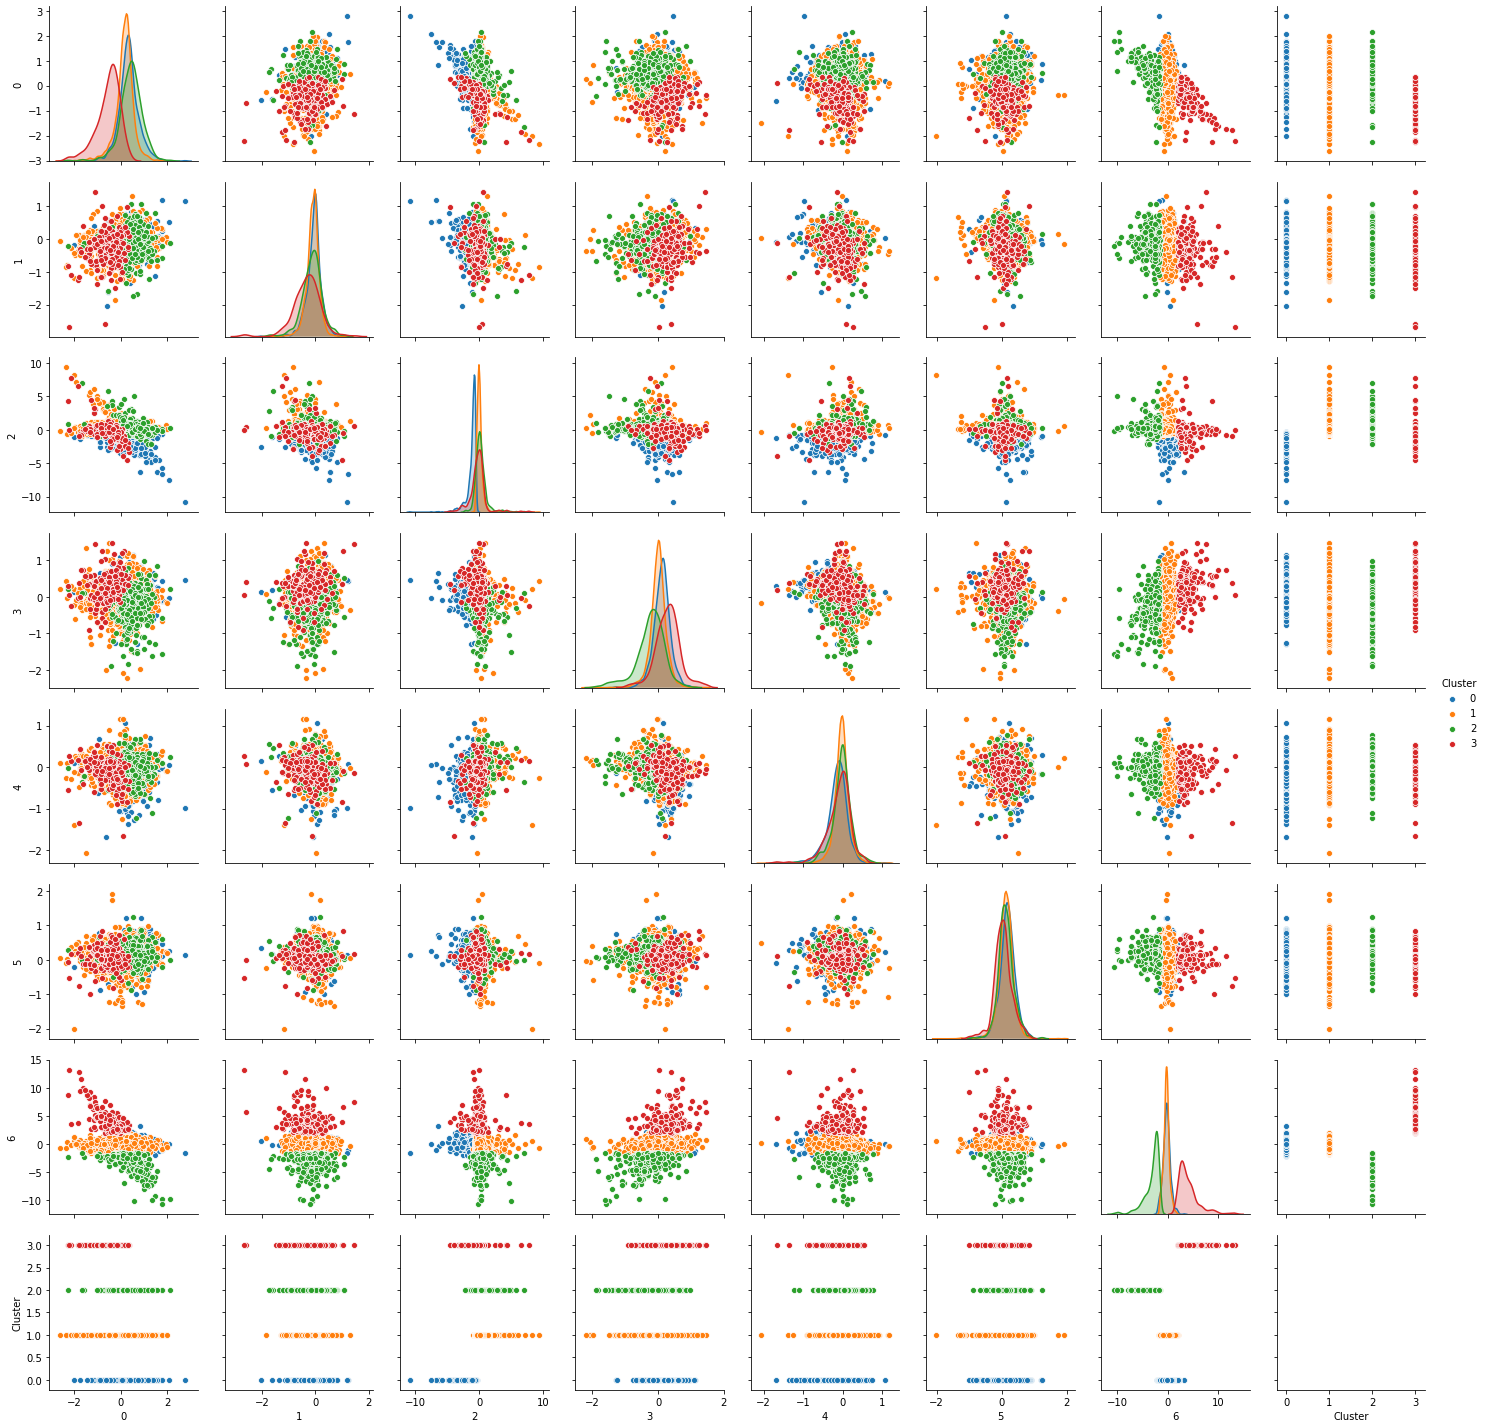

In [104]:
sns.pairplot(pd.DataFrame(X),hue='Cluster')

On peut identifier les clusters à des individus qui aiment certains catégories.

## Méthode de factorisation matricielle

In [105]:
import sys
sys.setrecursionlimit(10000)

 On décide maintenant d'utiliser la méthode de factorisation matricielle afin de résoudre notre problème initial, cette méthode non supervisée se base sur des latent features dont on cherchera à déterminer le nombre optimal, cette méthode nous permet de prédire l'ensemble des notes que les utilisateurs donneraient aux films.

In [106]:
import random as rd

In [107]:
def data_set(dat=ratings,col='UserID',alpha=0.8):
    data=dat.copy()
    users=data[col].unique()
    random=[rd.uniform(0,1) for k in range (0,data.shape[0])]
    data['rd']=random
    training=data[data['rd']<alpha]
    for i in users:
        index=data[col]==i
        training_user=data[index].reset_index()
        training_user=training_user.loc[0]
        training_user=training_user.to_frame().T
        if training.merge(training_user,how='inner').shape[0]==0:
            training=training.merge(training_user)

        #On garde au moins une note pour chaque utilisateur 
    training=pd.concat([training,data[data['rd']<alpha]],join='outer',sort=False)
    test=data[data['rd']>alpha]
    del training['rd']
    del test['rd']
    return(training,test)

In [108]:
#On split la base de données afin de vérifier nos résultats
training,test = data_set(ratings,'UserID',0.8)

In [109]:
notes_training=training.pivot(index='UserID',columns='MovieID',values='Rating')

In [110]:
notes_test=test.pivot(index='UserID',columns='MovieID',values='Rating')

In [111]:
notes_training_standard=standard(notes_training.T,notes_training.T)
notes_test_standard=standard(notes_test.T,notes_training.T)

On cherche à optimiser la valeur de nombre de latent feature. On regarde la variation d'écart pour un jeu de donnée selon le nombre choisi.

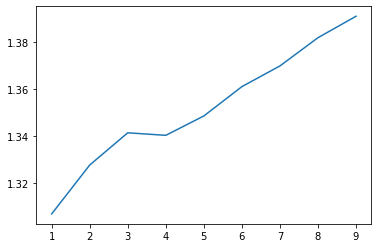

In [112]:
erreur=[]
x=[]
for i in range (1,10):
    note_estimate=(pd.DataFrame(emsvd(notes_training_standard.astype(float),k=i)[0]))
    e=(note_estimate-notes_test_standard)**2
    erreur.append(e.mean().mean())
    x.append(i)
plt.plot(x,erreur)

In [113]:
print(min(erreur))

1.3070204646263832


On choisit un modèle à 1 latent feature

In [134]:
n_features=1
notes_test_standard['Cluster']=X['Cluster']
erreur=0
for i in range(0,4):
    notes_cluster=notes_training_standard[notes_test_standard['Cluster']==i]
    #del notes_cluster['UserID']
    test_cluster=notes_test_standard[notes_test_standard['Cluster']==i]
    #del test_cluster['UserID']
    del test_cluster['Cluster']
    notes_cluster_estimate=pd.DataFrame(emsvd(notes_cluster.astype(float),k=n_features)[0])
    e=(notes_cluster_estimate-test_cluster)**2
    erreur+=e.mean().mean()

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

Mean of empty slice



In [135]:
print(erreur/4)

1.3703214373683024


On constate que l'erreur quadratique moyenne ne diminue pas lorsqu'on divise la matrice en cluster d'individu aux gouts similaires, on garde une erreur moyenne importante, mais le clustering d'individus permet une légère amélioration des résultats obtenus. Le temps de calculs nécessaire est également largement diminué.

In [116]:
n_features=2
notes_test_standard['Cluster']=X['Cluster']
erreur=0
for i in range(0,4):
    notes_cluster=notes_training_standard[notes_test_standard['Cluster']==i]
    #del notes_cluster['UserID']
    test_cluster=notes_test_standard[notes_test_standard['Cluster']==i]
    #del test_cluster['UserID']
    del test_cluster['Cluster']
    notes_cluster_estimate=pd.DataFrame(emsvd(notes_cluster.astype(float),k=n_features)[0])
    e=(notes_cluster_estimate-test_cluster)**2
    erreur+=e.mean().mean()

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

Mean of empty slice

/Users/zal/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1843: RuntimeWarning:

invalid value encountered in greater



In [118]:
print(erreur/4)

1.2958238019100752
